<a href="https://colab.research.google.com/github/zuobinxiong/CS789/blob/main/Lab2_Evasion_Attack_on_Inceptionv3_student.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Inception V3
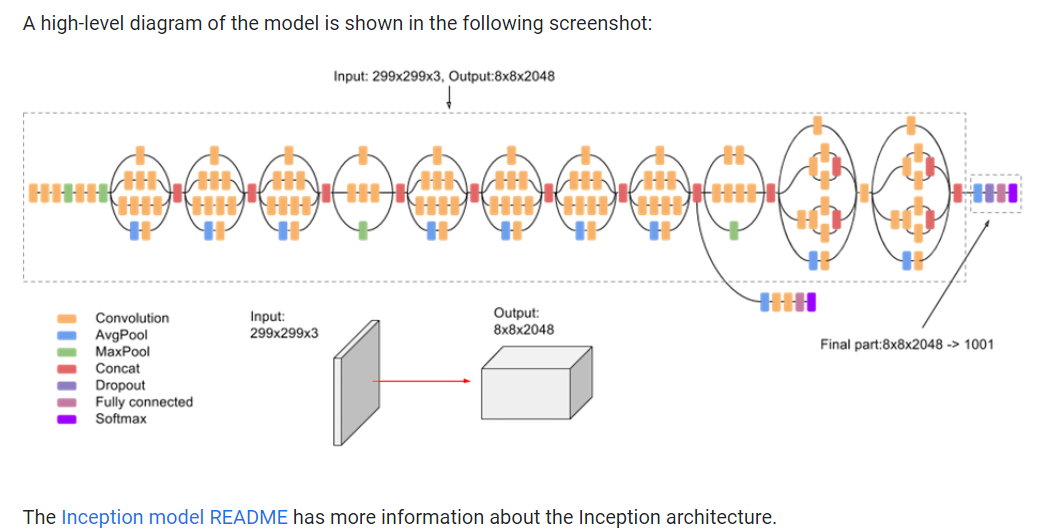

In [1]:
#import required libs
import torch
import torch.nn
import torch.nn.functional as F
import torchvision.models as models
from PIL import Image
from torchvision import transforms
import numpy as np
import requests, io
import matplotlib.pyplot as plt
from torch.autograd import Variable
%matplotlib inline

Here, we will use pre-trained inceptionv3 model. You can use VGG or any other model you want. But you have to make some changes in this code (i.e input size). Since inceptionv3 uses dropout and batch normalization whose behavior at evaluation time differs from the train time, we need to set it to the `eval()` mode.

In [2]:
inceptionv3 = models.inception_v3(pretrained=True) #download and load pretrained inceptionv3 model
inceptionv3.eval();

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=Inception_V3_Weights.IMAGENET1K_V1`. You can also use `weights=Inception_V3_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Next, we will load an image using requests and PIL. Feel free to use image of your choice.

In [3]:
url = "https://raw.githubusercontent.com/zuobinxiong/CS789/main/mydog.jpg"
response = requests.get(url)
img = Image.open(io.BytesIO(response.content))

In [ ]:
plt.imshow(img)

In [5]:
#mean and std will remain same irresptive of the model you use
mean=[0.485, 0.456, 0.406]
std=[0.229, 0.224, 0.225]

preprocess = transforms.Compose([
                transforms.Resize((299,299)),
                transforms.ToTensor(),
                transforms.Normalize(mean, std)
            ])

In [42]:
# add you code to preprocess the image (img) to the required shape (3,299,299)
image_tensor =
# adjust shape to fit the required input of inceptionv3 (B,C,H,W)
image_tensor =
image_tensor.shape

torch.Size([1, 3, 299, 299])

In [43]:
img_variable = Variable(image_tensor, requires_grad=True) #convert tensor into a variable

In [44]:
output = inceptionv3.forward(img_variable)
label_idx = torch.max(output.data, 1)[1][0]   #get an index(class number) of a largest element
print(label_idx)

tensor(209)


In [ ]:
labels_link = "https://raw.githubusercontent.com/anishathalye/imagenet-simple-labels/master/imagenet-simple-labels.json"
labels = requests.get(labels_link).json()
# labels = {int(idx):label for idx, label in labels_json.items()}
labels

In [46]:
x_pred = labels[label_idx]
print(x_pred)

Chesapeake Bay Retriever


In [47]:
#get probability distribution over 100 classes
output_probs =
x_pred_prob =
print(x_pred_prob)

tensor(74.5011)


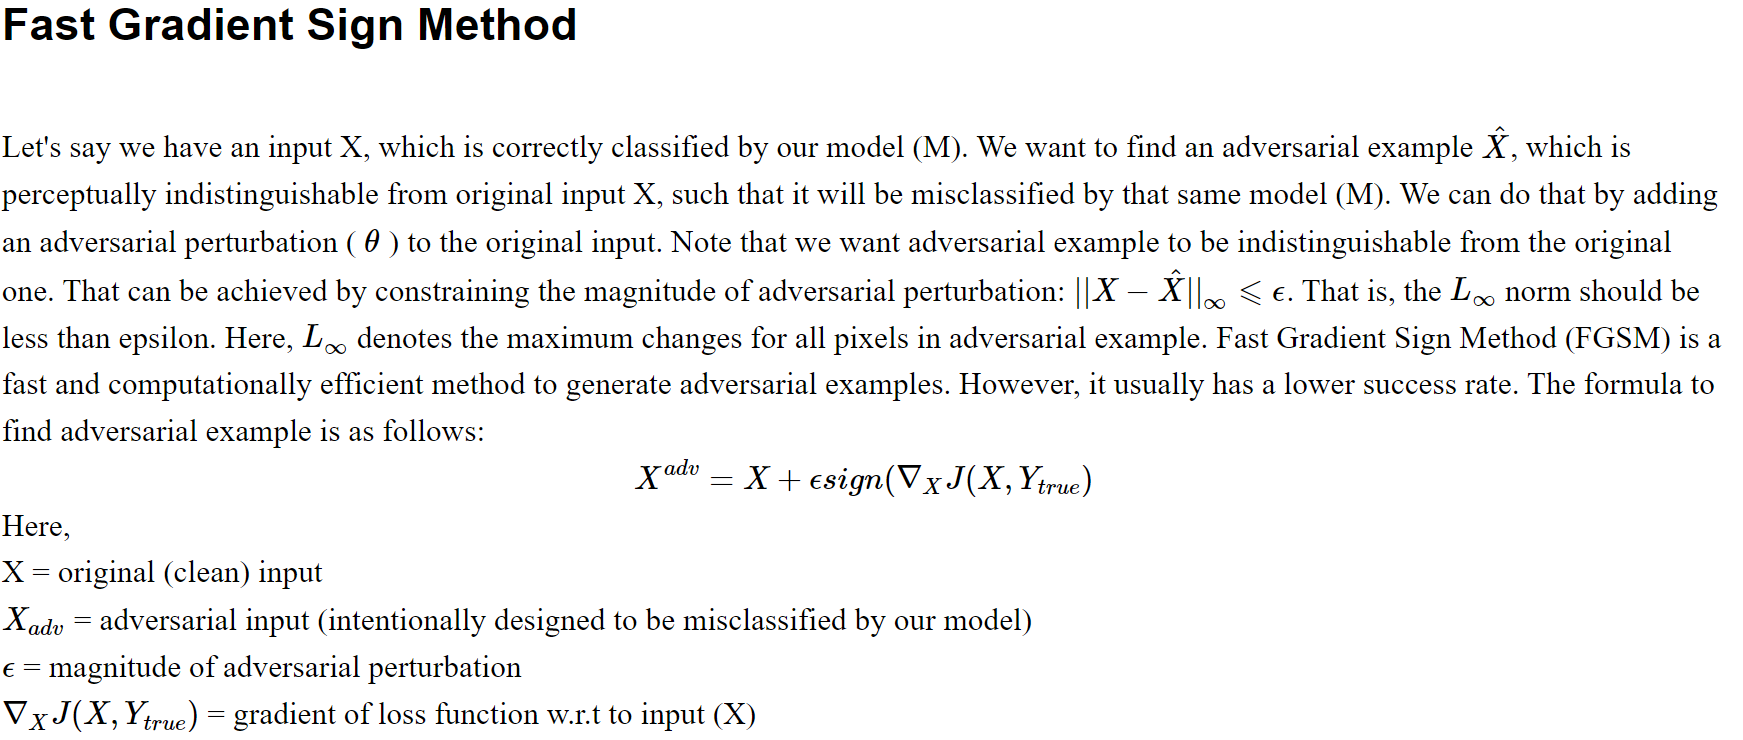

In [48]:
y_true = 209   #my dog  ##change this if you change input image
target = Variable(torch.LongTensor([y_true]), requires_grad=False)
print(target)

tensor([209])


In [49]:
#perform a backward pass in order to get gradients
loss = torch.nn.CrossEntropyLoss()
# 1 calculate loss value, your code
loss_cal =
# backprop calculate gradient, your code
#this will calculate gradient of each variable (with requires_grad=True) and can be accessed by "var.grad.data"


Following code cell computes the adversarial example using formula shown above.

In [ ]:
eps = 0.02
# 1 calculate the sign of gradient of the loss func (with respect to input X) (adv), gradient can be accessed by "var.grad.data"
x_grad =

#find adv example using formula shown above
x_adversarial =
x_adversarial

In [15]:
#perform a forward pass on adv example
output_adv = inceptionv3.forward(Variable(x_adversarial))
#classify the adv example
x_adv_pred = labels[torch.max(output_adv.data, 1)[1][0]]
#get probability distribution over classes
op_adv_probs =
#find probability (confidence) of a predicted class
adv_pred_prob =

In [16]:
print(x_adv_pred)
print(adv_pred_prob)

Chihuahua
tensor(21.6661)


In [17]:
def visualize(x, x_adv, x_grad, epsilon, clean_pred, adv_pred, clean_prob, adv_prob):

    x = x.squeeze(0)     #remove batch dimension # B X C H X W ==> C X H X W
    x = x.mul(torch.FloatTensor(std).view(3,1,1)).add(torch.FloatTensor(mean).view(3,1,1)).numpy()#reverse of normalization op- "unnormalize"
    x = np.transpose( x , (1,2,0))   # C X H X W  ==>   H X W X C
    x = np.clip(x, 0, 1)

    x_adv = x_adv.squeeze(0)
    x_adv = x_adv.mul(torch.FloatTensor(std).view(3,1,1)).add(torch.FloatTensor(mean).view(3,1,1)).numpy()#reverse of normalization op
    x_adv = np.transpose( x_adv , (1,2,0))   # C X H X W  ==>   H X W X C
    x_adv = np.clip(x_adv, 0, 1)

    x_grad = x_grad.squeeze(0).numpy()
    x_grad = np.transpose(x_grad, (1,2,0))
    x_grad = np.clip(x_grad, 0, 1)

    figure, ax = plt.subplots(1,3, figsize=(18,8))
    ax[0].imshow(x)
    ax[0].set_title('Clean Example', fontsize=20)


    ax[1].imshow(x_grad)
    ax[1].set_title('Perturbation', fontsize=20)
    ax[1].set_yticklabels([])
    ax[1].set_xticklabels([])
    ax[1].set_xticks([])
    ax[1].set_yticks([])


    ax[2].imshow(x_adv)
    ax[2].set_title('Adversarial Example', fontsize=20)

    ax[0].axis('off')
    ax[2].axis('off')

    ax[0].text(1.1,0.5, "+{}*".format(round(epsilon,3)), size=15, ha="center",
             transform=ax[0].transAxes)

    ax[0].text(0.5,-0.13, "Prediction: {}\n Probability: {}".format(clean_pred, clean_prob), size=15, ha="center",
         transform=ax[0].transAxes)

    ax[1].text(1.1,0.5, " = ", size=15, ha="center", transform=ax[1].transAxes)

    ax[2].text(0.5,-0.13, "Prediction: {}\n Probability: {}".format(adv_pred, adv_prob), size=15, ha="center",
         transform=ax[2].transAxes)


    plt.show()

In [ ]:
visualize(image_tensor, x_adversarial, x_grad, eps, x_pred, x_adv_pred, x_pred_prob, adv_pred_prob)

As you can see, the generated adversarial image is visually indistinguishable from the original image but inceptionv3 classifies it wrong. Now, let us generate several adversarial images with different values of epsilon. Notice that as we increase the value of epsilon the adversarial image becomes distinguishable from the original one.

In [19]:
epsilon = [0.00088, 0.004, 0.01, 0.12, 0.55]  # defien your own epsilons

In [ ]:
x_grad = torch.sign(img_variable.grad.data)
for i in epsilon:
  # construct an adv sample x_adversarial
  x_adversarial =
  # input to Inceptionv3 to get output scores
  output_adv =
  # get prediction result
  x_adv_pred =
  # calculate prediction probability
  op_adv_probs = F.softmax(output_adv, dim=1)
  adv_pred_prob = (torch.max(op_adv_probs.data, 1)[0][0]) * 100
  # visualize the result
  visualize(image_tensor, x_adversarial, x_grad, i, x_pred, x_adv_pred, x_pred_prob, adv_pred_prob)

For very small value of epsilon, class doesn't change. But it decreases the probability. An alternative way is to use raw gradient (not sign) without any constraint (epsilon). It is called as Fast Gradient Value Method.

In [21]:
#  you can try Fast Gradient Value Method here


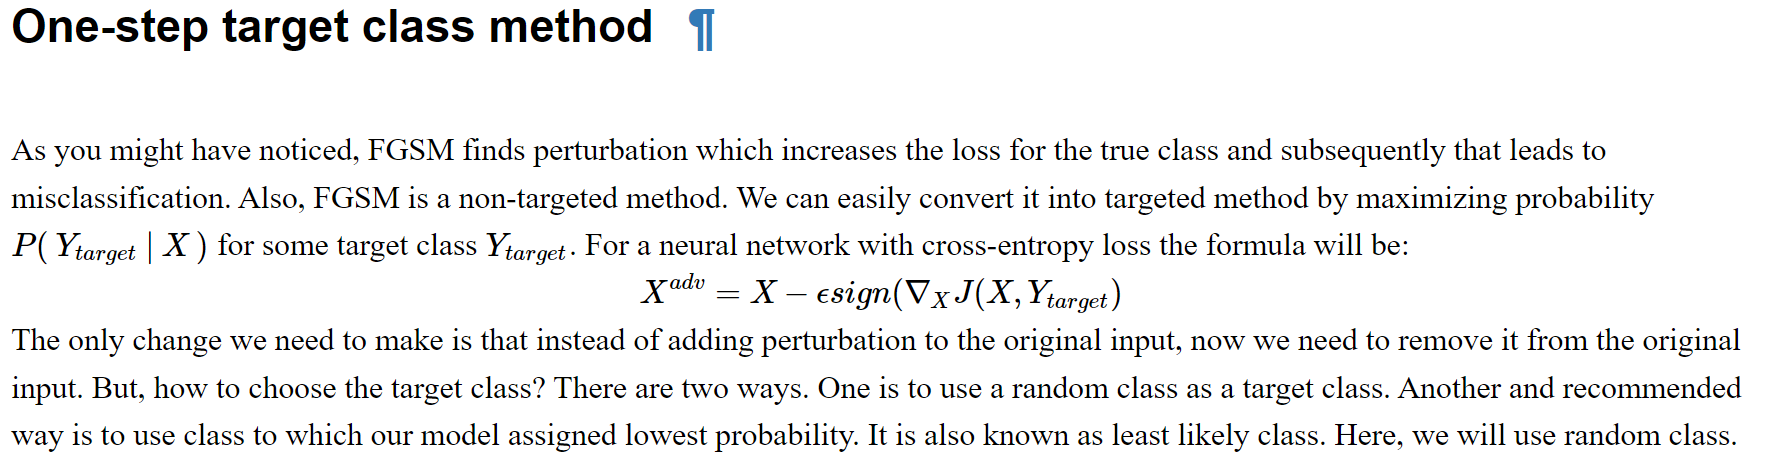

In [62]:
#targeted class can be a random class or the least likely class predicted by the network
y_target = 288   #leopard
y_target = Variable(torch.LongTensor([y_target]), requires_grad=False)
print(y_target)

tensor([288])


In [37]:
def zero_gradients(x):
    if isinstance(x, torch.Tensor):
        if x.grad is not None:
            x.grad.detach_()
            x.grad.zero_()
    elif isinstance(x, collections.abc.Iterable):
        for elem in x:
            zero_gradients(elem)

In [50]:
zero_gradients(img_variable)                       #flush gradients
loss_cal2 = loss(output, y_target)
loss_cal2.backward(retain_graph=True)

In [53]:
epsilons = [0.01, 0.1, 0.5, 0.7 ]

In [ ]:
x_grad = torch.sign(img_variable.grad.data)
for i in epsilons:
  # construct an adv sample x_adversarial
  x_adversarial =
  # input to Inceptionv3 to get output scores
  output_adv =
  # get prediction result
  x_adv_pred =
  # calculate prediction probability
  op_adv_probs = F.softmax(output_adv, dim=1)
  adv_pred_prob = (torch.max(op_adv_probs.data, 1)[0][0]) * 100
  # visualize the result
  visualize(image_tensor, x_adversarial, x_grad, i, x_pred, x_adv_pred, x_pred_prob, adv_pred_prob)

Seems like it doesn't work well here. You may try with other images and results might change. Let's move on to other method and see if it can generate better adversarial examples.

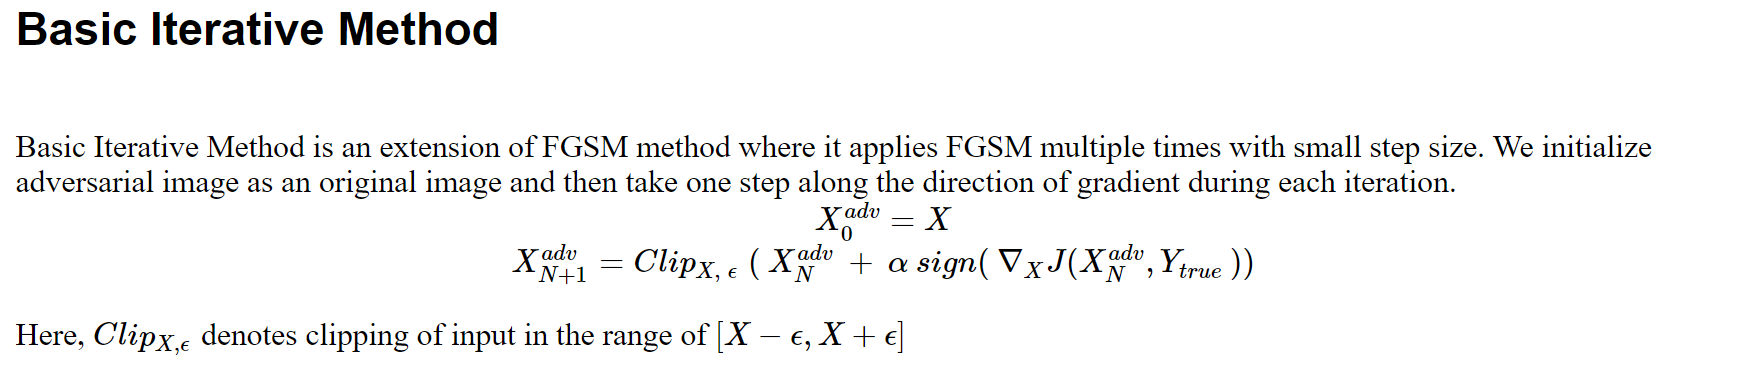

In [56]:
y_true = Variable( torch.LongTensor([209]), requires_grad=False)   #mydog
epsilon = 0.25
num_steps = 5
alpha = 0.025
#above three are hyperparameters

In [57]:
for i in range(num_steps):
  zero_gradients(img_variable)                       #flush gradients
  output = inceptionv3.forward(img_variable)         #perform forward pass
  loss = torch.nn.CrossEntropyLoss()
  loss_cal = loss(output, y_true)
  loss_cal.backward()
  # 1 as per the formula, calculate gradient direction
  x_grad =
  # 2 add perturbation to img_variable which also contains perturbation from previous iterations
  adv_temp =
  # 3 total perturbation
  total_grad =
  # 4 clip perturbation range in (-epsilon, epsilon)
  total_grad =
  # 5 add total perturbation to the original image
  x_adv =
  img_variable.data = x_adv

#final adversarial example can be accessed at- img_variable.data

In [ ]:
output_adv = inceptionv3.forward(img_variable)
x_adv_pred = labels[torch.max(output_adv.data, 1)[1][0]]  #classify adversarial example
output_adv_probs = F.softmax(output_adv, dim=1)
x_adv_pred_prob =  (torch.max(output_adv_probs.data, 1)[0][0]) * 100
visualize(image_tensor, img_variable.data, total_grad, epsilon, x_pred,x_adv_pred, x_pred_prob,  x_adv_pred_prob)  #class and prob of original ex will remain same

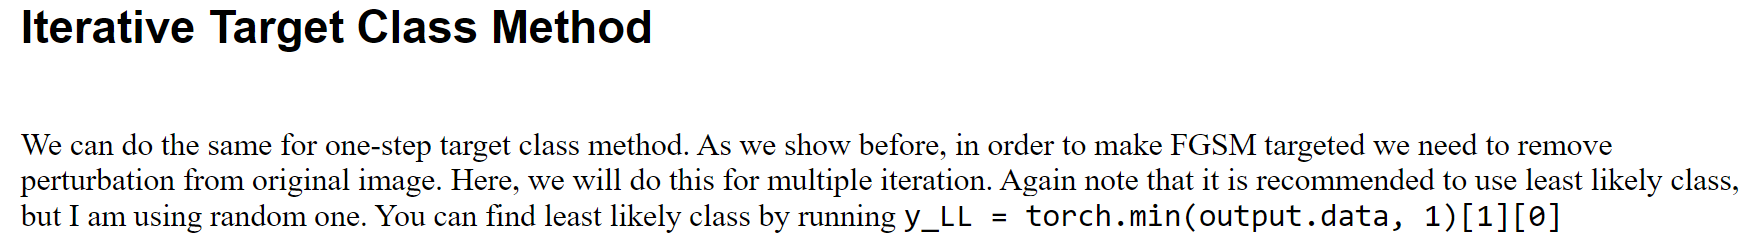

In [71]:
y_target = Variable(torch.LongTensor([288]), requires_grad=False)    #9= ostrich
epsilon = 0.25
num_steps = 5
alpha = 0.025

In [72]:
img_variable.data = image_tensor   #in previous method we assigned it to the adversarial img

In [75]:
for i in range(num_steps):
  zero_gradients(img_variable)
  output = inceptionv3.forward(img_variable)
  loss = torch.nn.CrossEntropyLoss()
  loss_cal = loss(output, y_target)
  loss_cal.backward()
  # 1 as per the formula, calculate gradient direction
  x_grad =
  # 2 add perturbation to img_variable which also contains perturbation from previous iterations
  adv_temp =
  # 3 total perturbation
  total_grad =
  # 4 clip perturbation range in (-epsilon, epsilon)
  total_grad =
  # 5 add total perturbation to the original image
  x_adv = image_tensor + total_grad
  img_variable.data = x_adv


In [ ]:
output_adv = inceptionv3.forward(img_variable)
x_adv_pred = labels[torch.max(output_adv.data, 1)[1][0]]
output_adv_probs = F.softmax(output_adv, dim=1)
x_adv_pred_prob =  (torch.max(output_adv_probs.data, 1)[0][0]) * 100
visualize(image_tensor, img_variable.data, total_grad, epsilon, x_pred,x_adv_pred, x_pred_prob,  x_adv_pred_prob)